# General trace loader
Interface for loading various traces. Tasks include:
- Resolving class imbalance (TODO)
- Noise reduction (TODO)
- Switching between variants of fixed key / random key traces (TODO)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from tools.cache import cache_np
from tools.traceloader import ASCAD, TraceGroup, TraceCategory

sns.set_style("whitegrid")

In [2]:
ascad = ASCAD()
ascad.default.profile.traces.shape

(200000, 1400)

In [3]:
ascad.default.profile.filter_traces(1).shape

(768, 1400)

In [15]:
from data.loader.ascad import ASCADData

print(ASCADData.random_key()["Profiling_traces"]['labels'][0])

125


In [18]:
masked_byte_ix = 2
full_key_ix = 1
label_len = range(len(ASCADData.random_key()["Profiling_traces"]["labels"]))

bytearray(ASCADData.random_key()["Profiling_traces"]["metadata"][0])

bytearray(b"\xb15\xbe\x1cd\xa7\x9d\x1e\xe8X\x12!\'\x11N[\x07\xab\xadVl@\xfe8\x02M\xa7+\x995\xf8\xa9\x00\x00\xec\x84R\n\xd0\xd6\x85\x00X\xd0/\xc6\x0eG.:\x00\x00\x00\x00")

<AxesSubplot:>

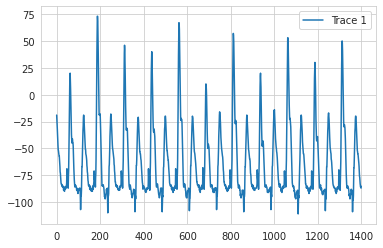

In [5]:
T1 = ascad.default.profile.traces[0]
sns.lineplot(data=pd.DataFrame(T1, columns=["Trace 1"]))

### Plot of a small section of two traces

<AxesSubplot:>

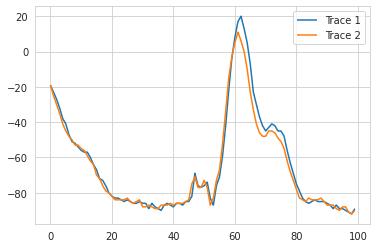

In [6]:
T2 = ascad.default.profile.traces[1]
sns.lineplot(dashes=[(1, 0), (1, 0)], data=pd.DataFrame(list(zip(T1, T2))[:100], columns=["Trace 1", "Trace 2"]))

<AxesSubplot:>

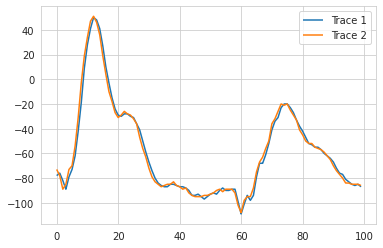

In [7]:
sns.lineplot(dashes=[(1, 0), (1, 0)], data=pd.DataFrame(list(zip(T1, T2))[-100:], columns=["Trace 1", "Trace 2"]))

### Mean of ASCAD traces.

In [8]:
print(f"Profiling trace mean: {ascad.default.profile.traces.mean():.2f},\n"
      f"Attack trace mean: {ascad.default.attack.traces.mean():.2f}")

Profiling trace mean: -63.59,
Attack trace mean: -63.67


### Variance of ASCAD traces.

In [9]:
print(f"Profiling trace variance: {ascad.default.profile.traces.var():.2f},\n"
      f"Attack trace variance: {ascad.default.attack.traces.var():.2f}")

Profiling trace variance: 1149.78,
Attack trace variance: 1138.65


### Mean and variance between all traces.

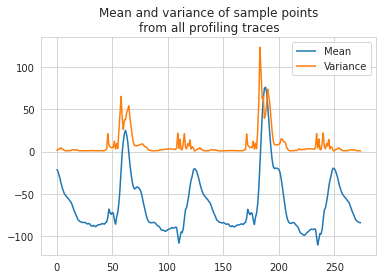

In [10]:
import matplotlib.pyplot as plt

DEFAULT_CUTOFF = 275

def plot_mv_traces(traces, cutoff=DEFAULT_CUTOFF):
    df_mv = pd.DataFrame(list(zip(traces.mean(axis=0), traces.var(axis=0)))[:cutoff], columns=["Mean", "Variance"])

    title = "Mean and variance of sample points\nfrom all profiling traces"
    sns.lineplot(dashes=[(1, 0), (1, 0)], data=df_mv).set_title(title)

def mv_diff(left, right):
    mean_diff = left.mean(axis=0) - right.mean(axis=0)
    var_diff = left.var(axis=0) - right.var(axis=0)

    return mean_diff, var_diff

def plot_mv_diff(left, right, title, cutoff=DEFAULT_CUTOFF):
    cols = ["Mean difference", "Variance difference"]
    df_mv_diff = pd.DataFrame(list(zip(*mv_diff(left, right)))[:cutoff], columns=cols)
    sns.lineplot(data=df_mv_diff[cols[0]])

    ax2 = plt.twinx()
    sns.lineplot(data=df_mv_diff[cols[1]], color=sns.color_palette()[1], ax=ax2).set_title(title)


plot_mv_traces(ascad.default.profile.traces)

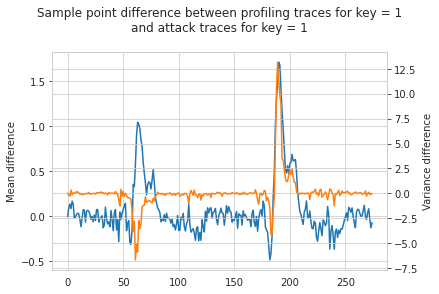

In [11]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 1\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(1), TITLE)


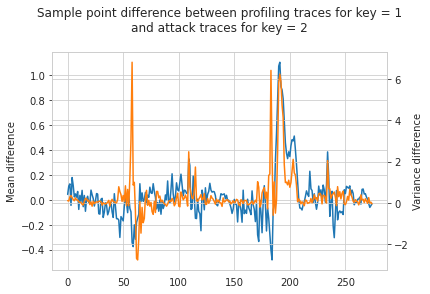

In [12]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 2\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(2), TITLE)

# Finding Points of Interest

In [13]:
from scipy import stats

### Order difference detection tool

In [14]:
def statistical_moment(traces, moment=1):
    if moment == 1:
        return traces.mean(axis=0)
    if moment == 2:
        return traces.var(axis=0)
    if moment == 3:
        return stats.skew(traces, axis=0)
    if moment == 4:
        return stats.kurtosis(traces, axis=0)

    raise Exception("Moment not implemented.")

def calc_moment_difference(ts, moment=1):
    kr = range(ASCAD.key_size)

    s_moment = lambda a: statistical_moment(a, moment)

    if isinstance(ts, TraceGroup):
        left = np.array([s_moment(ts.profile.filter_traces(k)) for k in kr])
        right = np.array([s_moment(ts.attack.filter_traces(k)) for k in kr])
    elif isinstance(ts, TraceCategory):
        left, right = [], []

        for k in kr:
            traces = ts.filter_traces(k)
            mid = round(len(traces) / 2)
            print(len(traces))
            left.append(s_moment(traces[mid:]))
            right.append(s_moment(traces[:mid]))
    else:
        raise TypeError(f"Traces should be contained by TraceGroup or TraceCategory, not {type(ts)}.")

    dist_neq = [abs(left[i] - right[j]) for i in kr for j in kr if i != j]
    dist_eq = [abs(left[i] - right[i]) for i in kr]

    print(np.mean(dist_neq, axis=0) - np.mean(dist_eq, axis=0))
    raise Exception()

def get_moment_differences(ts, trace_size=ASCAD.trace_len, max_moment=3):
    mdiff = [calc_moment_difference(ts, i) for i in range(1, max_moment + 1)]

    return np.array([np.zeros(trace_size), *mdiff])

# M_DIFF_PATT = cache_np("mdiff_prof_att", get_moment_differences, ascad.default, v=1)
# M_DIFF_PROF = cache_np("mdiff_prof", get_moment_differences, ascad.default.profile, v=1)
M_DIFF_MASK = cache_np("mdiff_mask", get_moment_differences, ascad.masked.profile, v=1)

# TODO try window = 100, strange result.
def select_poi(diff, window=15):
    """
    Selects the top n most interesting points of interest, based on some statistical moment difference.
    """
    std = np.std(diff)
    # We are only interested in large distances between sample points in non-equal keys and
    #   small distances in sample points between equal keys.
    ts = [*(diff > std), *([False] * window)]

    acc = []
    counter, sum_diff, max_diff = 0, 0.0, 0.0
    for ix in range(len(ts)):
        if ts[ix]:
            counter += 1
            sum_diff += diff[ix]
            max_diff = max(diff[ix], max_diff)

        elif counter >= window:
            avg_diff = sum_diff / counter

            if avg_diff > 2 * std:
                acc.append((ix - counter, ix, avg_diff))

            counter, sum_diff, max_diff = 0, 0.0, 0.0

    if len(acc) == 0:
        return []

    return pd.DataFrame(acc).sort_values(2, ascending=False)[[0,1]].values

def plot_poi(mdiff, moment):
    fig, ax = plt.subplots()

    title = f"Difference in statistical moment ({moment}) between traces with\n" \
            f"different keys, Points of Interest are highlighted.\n"
    sns.lineplot(data=mdiff[moment]).set_title(title)

    for a, b in select_poi(mdiff[moment]):
        ax.axvspan(a, b, alpha=0.3, color=sns.color_palette()[3])

    plt.show()

def plot_poi_trace(trace, poi):
    fig, ax = plt.subplots()

    title = f"Some power trace, Points of Interest are highlighted.\n"
    sns.lineplot(data=trace, palette=[sns.color_palette()[4]]).set_title(title)

    for a, b in poi:
        ax.axvspan(a, b, alpha=0.3, color=sns.color_palette()[3])

    plt.show()

plot_poi(M_DIFF_PROF, 1)

753
840
823
814
716
767
782
729
775
803
807
787
766
764
789
776
780
819
789
785
771
781
729
753
819
786
790
801
769
803
757
798
798
734
783
757
800
776
796
760
759
780
793
761
818
767
805
777
797
755
784
792
749
775
783
760
779
740
757
806
753
770
841
733
802
784
758
743
796
775
791
789
803
788
786
790
744
809
738
830
739
821
806
754
779
795
818
761
776
782
792
757
782
771
786
796
784
846
805
775
817
820
800
749
797
790
750
778
784
738
806
788
800
798
786
758
760
785
787
801
771
832
749
783
797
823
765
764
820
786
761
780
801
787
767
770
767
833
768
814
783
771
787
806
759
761
784
748
813
749
788
806
779
772
821
745
741
709
779
760
786
790
816
728
752
792
724
818
736
759
783
789
793
802
778
787
834
759
742
807
814
759
745
835
813
741
765
759
821
801
749
829
788
812
791
783
795
761
758
787
764
780
791
784
778
806
775
796
775
808
782
764
812
781
797
780
805
791
802
797
820
802
825
726
810
772
768
747
791
747
844
812
773
743
852
773
712
782
755
738
751
741
819
768
757
761
755
800
812
790


Exception: 

#### Points of interest

In [ ]:
select_poi(M_DIFF_PROF[1])

#### Points of interest with power trace

In [ ]:
plot_poi_trace(pd.DataFrame(T1, columns=["Trace 1"]), select_poi(M_DIFF_PROF[1]))

### PoI for the variance

In [ ]:
plot_poi(M_DIFF_PROF, 2)

### PoI for the skewness

In [ ]:
plot_poi(M_DIFF_PROF, 3)

In [ ]:
plot_poi(M_DIFF_PATT, 1)